Import torch modules


In [1]:
from transformers import AutoTokenizer, BertModel, BertConfig
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-6
num_epoches = 200

weighted loss initilize

In [3]:
def get_weight(dataloader, num_intent_classes, num_type_classes, device):
    count_y_label = [0] * num_intent_classes
    count_y_tag = [0] * num_type_classes

    for train_x, (train_y_label, train_y_tag) in dataloader:
        for idx in range(len(train_y_label)):
            count_y_label[train_y_label[idx]] += 1 
            for k in range(len(train_y_tag[idx])):
                if train_y_tag[idx][k] == -100:
                    continue
                count_y_tag[train_y_tag[idx][k]] += 1
                
    intent_weight = torch.tensor([1 - c/sum(count_y_label) for c in count_y_label]).to(device)
    tag_weight = torch.tensor([1 - c/sum(count_y_tag) for c in count_y_tag]).to(device)
    
    return intent_weight, tag_weight

train model

In [5]:
from multi_linear_model import ModelMultiLinear
from single_linear_model import ModelSingleLinear 
from two_linear import ModelTwoLinear
import multi_linear_bert_no_grad
import attention_linear
from train import train
import dataloader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


#snips dataset
myData = dataloader.SlurpTrainData('./archive/snips', tokenizer)
myCollate = dataloader.SlurpCollate(myData.type_labels, myData.tokenizer)

validData = dataloader.SlurpValidData('./archive/snips', tokenizer)


train_dataloader = DataLoader(myData, batch_size=64, shuffle=True, collate_fn=myCollate)
valid_dataloader = DataLoader(validData, batch_size=64, shuffle=True, collate_fn=myCollate)

intent_weight, tag_weight = get_weight(train_dataloader, len(myData.intent_labels), len(myData.type_labels), device)

intent_criterion = nn.CrossEntropyLoss(weight=intent_weight)
tag_criterion = nn.CrossEntropyLoss(weight=tag_weight)
test_criterion = nn.CrossEntropyLoss()

"""
#Two Linear
myModel = ModelTwoLinear(model_name, len(myData.intent_labels), len(myData.type_labels))
save_path = './model_snips/two linear/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path, load=True, load_path='./model_snips/two linear/checkpoint.ptepoch75')

#multi linear
myModel = ModelMultiLinear(model_name, len(myData.intent_labels), len(myData.type_labels))
save_path = './model_snips/multi linear/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path)

#msingle linear
myModel = ModelSingleLinear(model_name, len(myData.intent_labels), len(myData.type_labels))
save_path = './model_snips/single linear/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path)


#attention 3 
myModel = attention_linear.Model(len(myData.intent_labels), len(myData.type_labels), num_hidden_layers=3)
save_path = './model_snips/attention3/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path)



#freeze bert
myModel = multi_linear_bert_no_grad.Model(model_name, len(myData.intent_labels), len(myData.type_labels))
save_path = './model_snips/multi linear freeze bert/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path)
"""


#slurp dataset
myData = dataloader.SlurpTrainData('./archive/slurp', tokenizer)
myCollate = dataloader.SlurpCollate(myData.type_labels, myData.tokenizer)

validData = dataloader.SlurpValidData('./archive/slurp', tokenizer)
testData = dataloader.SlurpTestData('./archive/slurp', tokenizer)

train_dataloader = DataLoader(myData, batch_size=64, shuffle=True, collate_fn=myCollate)
valid_dataloader = DataLoader(validData, batch_size=64, shuffle=True, collate_fn=myCollate)
test_dataloader = DataLoader(testData, batch_size=64, shuffle=True, collate_fn=myCollate)

intent_weight, tag_weight = get_weight(train_dataloader, len(myData.intent_labels), len(myData.type_labels), device)

intent_criterion = nn.CrossEntropyLoss(weight=intent_weight)
tag_criterion = nn.CrossEntropyLoss(weight=tag_weight)
test_criterion = nn.CrossEntropyLoss()

"""
#Two Linear
myModel = ModelTwoLinear(model_name, len(myData.intent_labels), len(myData.type_labels))
save_path = './model_slurp/two linear/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path)

#multi linear
myModel = ModelMultiLinear(model_name, len(myData.intent_labels), len(myData.type_labels))
save_path = './model_slurp/multi linear/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path)

#msingle linear
myModel = ModelSingleLinear(model_name, len(myData.intent_labels), len(myData.type_labels))
save_path = './model_slurp/single linear/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path)


#freeze bert
myModel = multi_linear_bert_no_grad.Model(model_name, len(myData.intent_labels), len(myData.type_labels))
save_path = './model_slurp/multi linear freeze bert/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path, load=True, load_path='./model_slurp/multi linear freeze bert/checkpoint.ptepoch50')

#attention 3 
myModel = attention_linear.Model(len(myData.intent_labels), len(myData.type_labels), num_hidden_layers=3)
save_path = './model_slurp/attention3/checkpoint.pt'
optimizer = torch.optim.Adam(params=myModel.parameters(), lr=learning_rate, weight_decay=1e-5)

torch.cuda.empty_cache()

train(model=myModel,
        optimizer=optimizer,
        device=device, 
        num_epoches=200, 
        tag_criterion=tag_criterion,
        intent_criterion=intent_criterion, 
        test_criterion=test_criterion,
        train_dataloader=train_dataloader, 
        valid_dataloader=valid_dataloader,
        save_path=save_path)
        
        """

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch : 51
intent error: 1.544798, tag error: 0.857283
saving new best model
validation error: 1.886853
saving model,optimizer parameters
Epoch : 52
intent error: 1.533046, tag error: 0.847851
saving new best model
validation error: 1.881309
saving model,optimizer parameters
Epoch : 53
intent error: 1.522163, tag error: 0.844023
saving new best model
validation error: 1.851349
saving model,optimizer parameters
Epoch : 54
intent error: 1.504824, tag error: 0.835783
validation error: 1.857846
saving model,optimizer parameters
Epoch : 55
intent error: 1.496106, tag error: 0.825782
saving new best model
validation error: 1.847009
saving model,optimizer parameters
Epoch : 56
intent error: 1.489824, tag error: 0.828392
saving new best model
validation error: 1.843717
saving model,optimizer parameters
Epoch : 57
intent error: 1.468820, tag error: 0.816901
saving new best model
validation error: 1.821444
saving model,optimizer parameters
Epoch : 58
intent error: 1.467280, tag error: 0.815046
s

Epoch : 114
intent error: 1.081321, tag error: 0.613434
saving new best model
validation error: 1.484372
saving model,optimizer parameters
Epoch : 115
intent error: 1.083008, tag error: 0.612899
saving new best model
validation error: 1.477346
saving model,optimizer parameters
Epoch : 116
intent error: 1.077842, tag error: 0.604147
validation error: 1.497406
saving model,optimizer parameters
Epoch : 117
intent error: 1.072739, tag error: 0.609040
saving new best model
validation error: 1.476996
saving model,optimizer parameters
Epoch : 118
intent error: 1.070333, tag error: 0.603230
saving new best model
validation error: 1.465043
saving model,optimizer parameters
Epoch : 119
intent error: 1.065647, tag error: 0.599955
validation error: 1.480331
saving model,optimizer parameters
Epoch : 120
intent error: 1.057373, tag error: 0.597924
validation error: 1.487091
saving model,optimizer parameters
Epoch : 121
intent error: 1.052072, tag error: 0.598337
saving new best model
validation erro

Epoch : 179
intent error: 0.885669, tag error: 0.488840
validation error: 1.346077
saving model,optimizer parameters
Epoch : 180
intent error: 0.878026, tag error: 0.488549
saving new best model
validation error: 1.344886
saving model,optimizer parameters
Epoch : 181
intent error: 0.889482, tag error: 0.489069
saving new best model
validation error: 1.338200
saving model,optimizer parameters
Epoch : 182
intent error: 0.893484, tag error: 0.490327
validation error: 1.346102
saving model,optimizer parameters
Epoch : 183
intent error: 0.883169, tag error: 0.487775
validation error: 1.359067
saving model,optimizer parameters
Epoch : 184
intent error: 0.886521, tag error: 0.482740
validation error: 1.350728
saving model,optimizer parameters
Epoch : 185
intent error: 0.889763, tag error: 0.484479
validation error: 1.346045
saving model,optimizer parameters
Epoch : 186
intent error: 0.875209, tag error: 0.481344
validation error: 1.345968
saving model,optimizer parameters
Epoch : 187
intent e

Epoch : 41
intent error: 1.691219, tag error: 1.082876
saving new best model
validation error: 2.298680
saving model,optimizer parameters
Epoch : 42
intent error: 1.657842, tag error: 1.069274
saving new best model
validation error: 2.290741
saving model,optimizer parameters
Epoch : 43
intent error: 1.621967, tag error: 1.055607
saving new best model
validation error: 2.233482
saving model,optimizer parameters
Epoch : 44
intent error: 1.586816, tag error: 1.042303
saving new best model
validation error: 2.214609
saving model,optimizer parameters
Epoch : 45
intent error: 1.554390, tag error: 1.026257
saving new best model
validation error: 2.184738
saving model,optimizer parameters
Epoch : 46
intent error: 1.514014, tag error: 1.013339
saving new best model
validation error: 2.156244
saving model,optimizer parameters
Epoch : 47
intent error: 1.491073, tag error: 0.999944
saving new best model
validation error: 2.129174
saving model,optimizer parameters
Epoch : 48
intent error: 1.454697,

saving new best model
validation error: 1.498347
saving model,optimizer parameters
Epoch : 104
intent error: 0.620550, tag error: 0.549098
saving new best model
validation error: 1.475292
saving model,optimizer parameters
Epoch : 105
intent error: 0.612909, tag error: 0.546761
validation error: 1.499136
saving model,optimizer parameters
Epoch : 106
intent error: 0.602698, tag error: 0.540021
validation error: 1.482198
saving model,optimizer parameters
Epoch : 107
intent error: 0.591620, tag error: 0.536323
validation error: 1.500395
saving model,optimizer parameters
Epoch : 108
intent error: 0.586368, tag error: 0.532880
validation error: 1.495198
saving model,optimizer parameters
Epoch : 109
intent error: 0.582952, tag error: 0.530540
validation error: 1.490199
saving model,optimizer parameters
Epoch : 110
intent error: 0.571436, tag error: 0.525201
saving new best model
validation error: 1.463969
saving model,optimizer parameters
Epoch : 111
intent error: 0.563461, tag error: 0.51757

validation error: 1.399797
saving model,optimizer parameters
Epoch : 171
intent error: 0.274515, tag error: 0.325916
validation error: 1.375329
saving model,optimizer parameters
Epoch : 172
intent error: 0.266517, tag error: 0.325416
validation error: 1.369522
saving model,optimizer parameters
Epoch : 173
intent error: 0.272589, tag error: 0.322866
validation error: 1.376128
saving model,optimizer parameters
Epoch : 174
intent error: 0.265098, tag error: 0.323885
validation error: 1.376735
saving model,optimizer parameters
Epoch : 175
intent error: 0.259282, tag error: 0.319301
validation error: 1.369218
saving model,optimizer parameters
Epoch : 176
intent error: 0.258605, tag error: 0.317387
validation error: 1.399377
saving model,optimizer parameters
Epoch : 177
intent error: 0.254638, tag error: 0.313061
saving new best model
validation error: 1.353424
saving model,optimizer parameters
Epoch : 178
intent error: 0.253413, tag error: 0.310870
validation error: 1.363820
saving model,op

tracking train

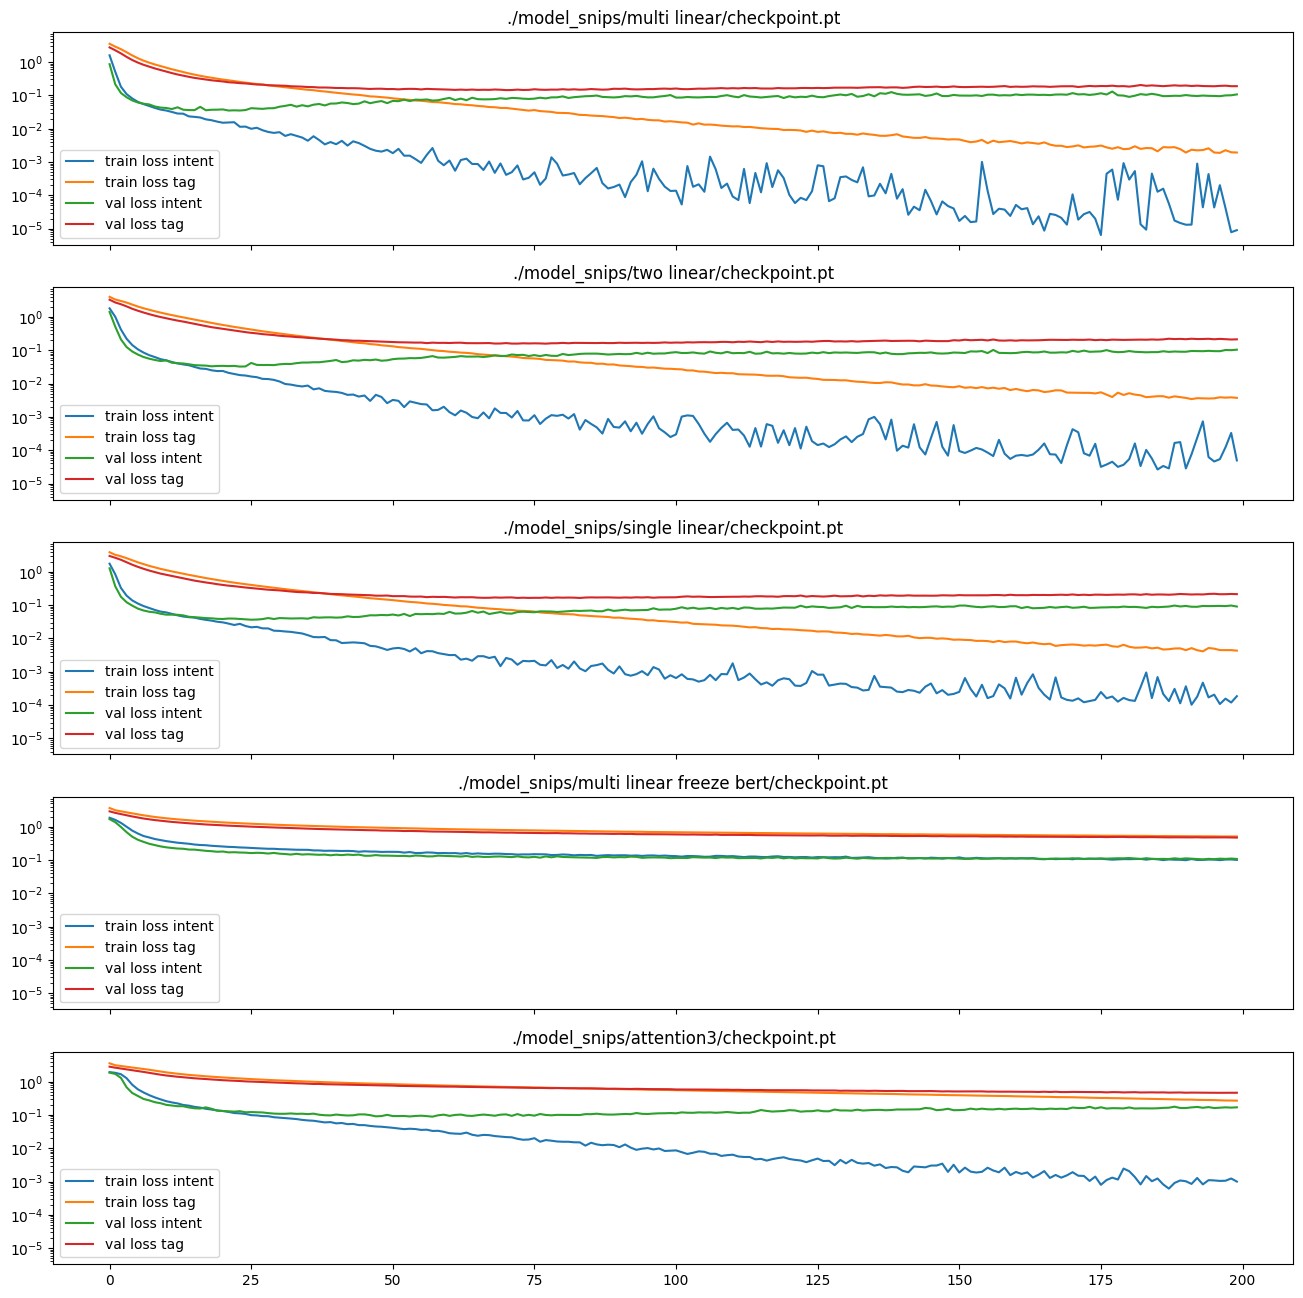

In [27]:
import matplotlib.pyplot as plt

save_path_list = ['./model_snips/multi linear/checkpoint.pt',
                 './model_snips/two linear/checkpoint.pt',
                 './model_snips/single linear/checkpoint.pt',
                 './model_snips/multi linear freeze bert/checkpoint.pt',
                 './model_snips/attention3/checkpoint.pt']

fig, axes = plt.subplots(5, 1, sharey = 'all', sharex='all', figsize=(16,16))

for i, save_path in enumerate(save_path_list):
    
    checkpoint = torch.load(save_path)
    intent_error = checkpoint['intent_error']
    tag_error = checkpoint['tag_error']
    best_error = checkpoint['best_error']
    val_error = checkpoint['val_error']
    
    t_error, val_intent, val_tag = zip(*val_error)
    val_intent = [v.item() for v in val_intent]
    val_tag = [v.item() for v in val_tag]
    
    ax = axes[i]
    ax.set_title(save_path)
    ax.plot(intent_error, label='train loss intent')
    ax.plot(tag_error, label='train loss tag')
    ax.plot(val_intent, label='val loss intent')
    ax.plot(val_tag, label='val loss tag')
    ax.legend()
    ax.set_yscale('log')
    
plt.show()
    

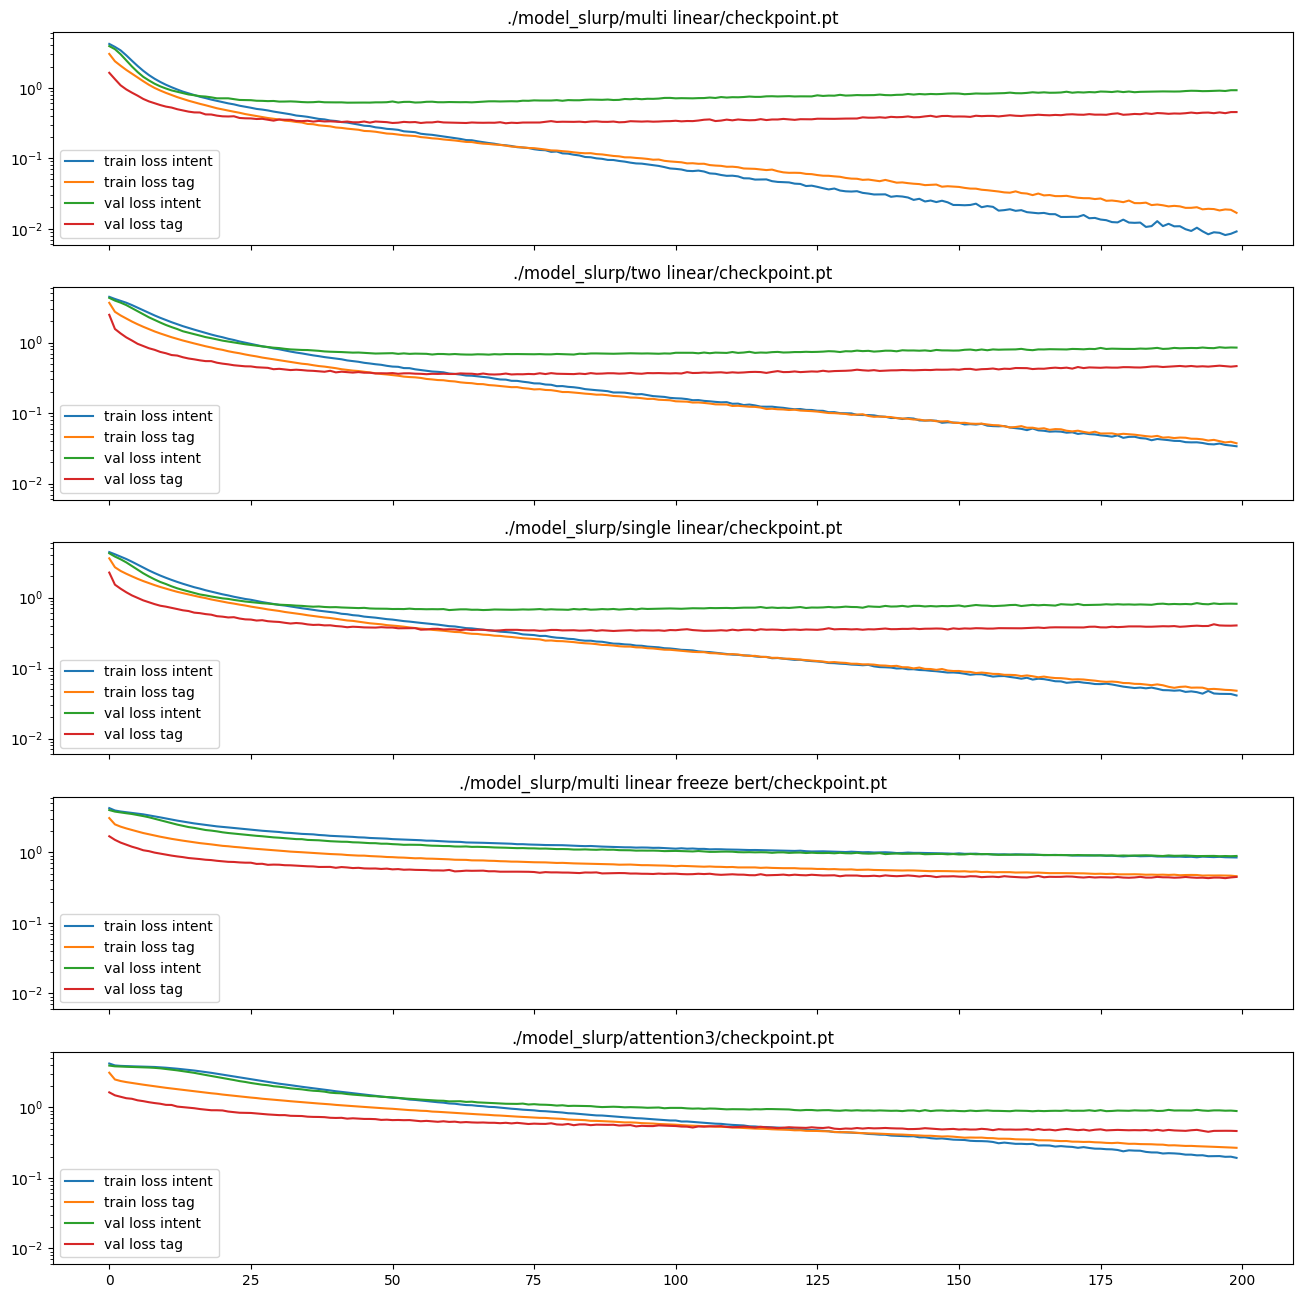

In [28]:
import matplotlib.pyplot as plt

save_path_list = ['./model_slurp/multi linear/checkpoint.pt',
                 './model_slurp/two linear/checkpoint.pt',
                 './model_slurp/single linear/checkpoint.pt',
                 './model_slurp/multi linear freeze bert/checkpoint.pt',
                 './model_slurp/attention3/checkpoint.pt']

fig, axes = plt.subplots(5, 1, sharey = 'all', sharex='all', figsize=(16,16))

for i, save_path in enumerate(save_path_list):
    
    checkpoint = torch.load(save_path)
    intent_error = checkpoint['intent_error']
    tag_error = checkpoint['tag_error']
    best_error = checkpoint['best_error']
    val_error = checkpoint['val_error']
    
    t_error, val_intent, val_tag = zip(*val_error)
    val_intent = [v.item() for v in val_intent]
    val_tag = [v.item() for v in val_tag]
    
    ax = axes[i]
    ax.set_title(save_path)
    ax.plot(intent_error, label='train loss intent')
    ax.plot(tag_error, label='train loss tag')
    ax.plot(val_intent, label='val loss intent')
    ax.plot(val_tag, label='val loss tag')
    ax.legend()
    ax.set_yscale('log')
    
plt.show()

test best model for each

In [4]:
from test import test
import dataloader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from multi_linear_model import ModelMultiLinear
from single_linear_model import ModelSingleLinear 
from two_linear import ModelTwoLinear
import multi_linear_bert_no_grad
import attention_linear

test_scores_snips=[]

test_criterion = nn.CrossEntropyLoss()

#snips
testData = dataloader.SlurpTestData('./archive/snips', tokenizer)
myCollate = dataloader.SlurpCollate(testData.type_labels, testData.tokenizer)

test_dataloader = DataLoader(testData, batch_size=64, shuffle=False, collate_fn=myCollate)

myModel = ModelTwoLinear(model_name, len(testData.intent_labels), len(testData.type_labels))
save_path = './model_snips/two linear/checkpoint.pt'

epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')

test_scores_snips.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))

myModel = ModelMultiLinear(model_name, len(testData.intent_labels), len(testData.type_labels))
save_path = './model_snips/multi linear/checkpoint.pt'
epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')
test_scores_snips.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))

myModel = ModelSingleLinear(model_name, len(testData.intent_labels), len(testData.type_labels))
save_path = './model_snips/single linear/checkpoint.pt'

epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')
test_scores_snips.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))

myModel = attention_linear.Model(len(testData.intent_labels), len(testData.type_labels), num_hidden_layers=3)
save_path = './model_snips/attention3/checkpoint.pt'

epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')
test_scores_snips.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))

myModel = multi_linear_bert_no_grad.Model(model_name, len(testData.intent_labels), len(testData.type_labels))
save_path = './model_snips/multi linear freeze bert/checkpoint.pt'

epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')
test_scores_snips.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))


#slurp
test_scores_slurp=[]


testData = dataloader.SlurpTestData('./archive/slurp', tokenizer)
myCollate = dataloader.SlurpCollate(testData.type_labels, testData.tokenizer)

test_dataloader = DataLoader(testData, batch_size=64, shuffle=False, collate_fn=myCollate)

myModel = ModelTwoLinear(model_name, len(testData.intent_labels), len(testData.type_labels))
save_path = './model_slurp/two linear/checkpoint.pt'

epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')

test_scores_slurp.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))

myModel = ModelMultiLinear(model_name, len(testData.intent_labels), len(testData.type_labels))
save_path = './model_slurp/multi linear/checkpoint.pt'
epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')

test_scores_slurp.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))

myModel = ModelSingleLinear(model_name, len(testData.intent_labels), len(testData.type_labels))
save_path = './model_slurp/single linear/checkpoint.pt'

epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')
test_scores_slurp.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))

myModel = attention_linear.Model(len(testData.intent_labels), len(testData.type_labels), num_hidden_layers=3)
save_path = './model_slurp/attention3/checkpoint.pt'

epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')
test_scores_slurp.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))

myModel = multi_linear_bert_no_grad.Model(model_name, len(testData.intent_labels), len(testData.type_labels))
save_path = './model_slurp/multi linear freeze bert/checkpoint.pt'

epoch, t_loss, intent_error, tag_error = test(model=myModel, 
                                         device=device, 
                                         test_criterion=test_criterion, 
                                         test_dataloader=test_dataloader, 
                                         load=True, 
                                         load_path=save_path+'best')
test_scores_slurp.append((save_path, epoch, t_loss, intent_error, tag_error))

print('test_score for ' + save_path +'best: total: %f, intent: %f, tag: %f' %(t_loss, intent_error, tag_error))


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_score for ./model_snips/two linear/checkpoint.ptbest: total: 0.324550, intent: 0.131680, tag: 0.192870


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_score for ./model_snips/multi linear/checkpoint.ptbest: total: 0.255591, intent: 0.087911, tag: 0.167680


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_score for ./model_snips/single linear/checkpoint.ptbest: total: 0.287108, intent: 0.105913, tag: 0.181195
test_score for ./model_snips/attention3/checkpoint.ptbest: total: 0.580281, intent: 0.129030, tag: 0.451251


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_score for ./model_snips/multi linear freeze bert/checkpoint.ptbest: total: 0.598943, intent: 0.115167, tag: 0.483776


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_score for ./model_slurp/two linear/checkpoint.ptbest: total: 0.984077, intent: 0.658887, tag: 0.325191


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_score for ./model_slurp/multi linear/checkpoint.ptbest: total: 0.873963, intent: 0.574982, tag: 0.298981


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_score for ./model_slurp/single linear/checkpoint.ptbest: total: 0.965676, intent: 0.636328, tag: 0.329348
test_score for ./model_slurp/attention3/checkpoint.ptbest: total: 1.292586, intent: 0.846851, tag: 0.445734


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


test_score for ./model_slurp/multi linear freeze bert/checkpoint.ptbest: total: 1.309066, intent: 0.886584, tag: 0.422482


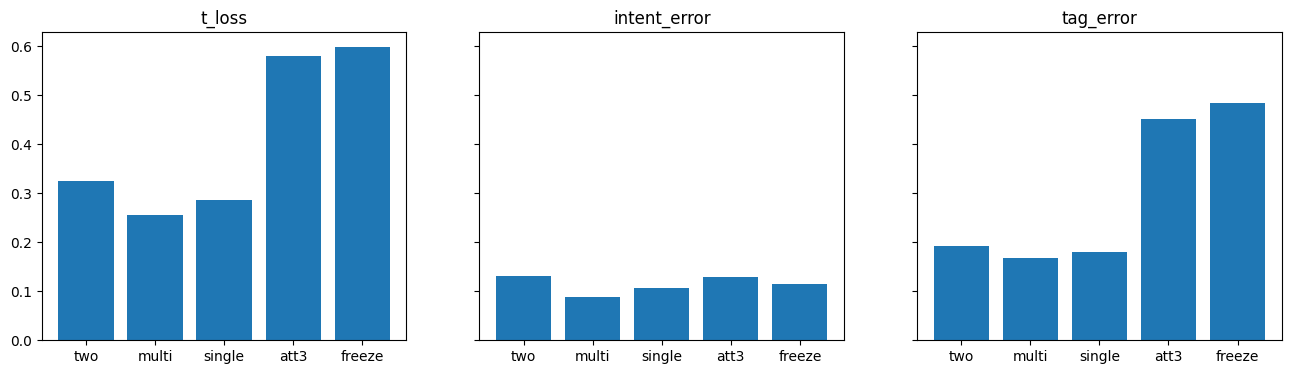

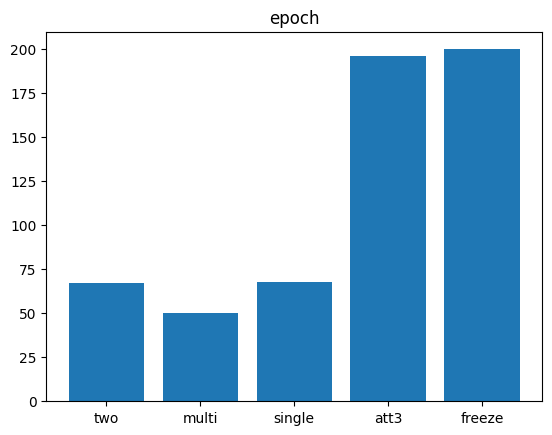

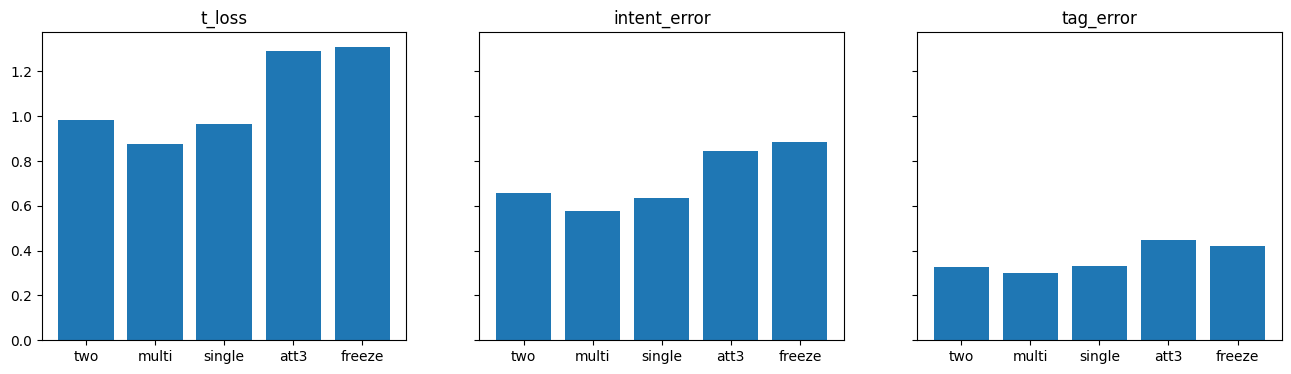

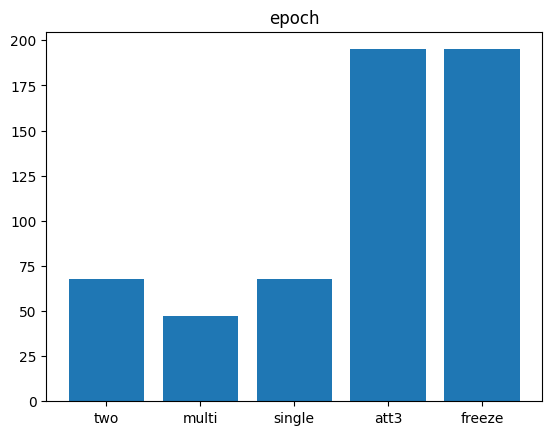

In [11]:
import matplotlib.pyplot as plt

#snips
fig, ax = plt.subplots(1, 3, sharey = 'all', figsize=(16,4))
titles, epoch, t_loss, intent_error, tag_error = zip(*test_scores_snips)

titles=['two', 'multi', 'single', 'att3', 'freeze']

x = range(len(test_scores_snips))

ax[0].set_title('t_loss')
ax[0].bar(x, t_loss)
ax[0].set_xticks(x, titles)

ax[1].set_title('intent_error')
ax[1].bar(x, intent_error)
ax[1].set_xticks(x, titles)

ax[2].set_title('tag_error')
ax[2].bar(x, tag_error)
ax[2].set_xticks(x, titles)


plt.show()

plt.title('epoch')
plt.bar(x, epoch)
plt.xticks(x, titles)
plt.show()


#slurp
fig, ax = plt.subplots(1, 3, sharey = 'all', figsize=(16,4))
titles, epoch, t_loss, intent_error, tag_error = zip(*test_scores_slurp)

titles=['two', 'multi', 'single', 'att3', 'freeze']

x = range(len(test_scores_slurp))

ax[0].set_title('t_loss')
ax[0].bar(x, t_loss)
ax[0].set_xticks(x, titles)

ax[1].set_title('intent_error')
ax[1].bar(x, intent_error)
ax[1].set_xticks(x, titles)

ax[2].set_title('tag_error')
ax[2].bar(x, tag_error)
ax[2].set_xticks(x, titles)


plt.show()

plt.title('epoch')
plt.bar(x, epoch)
plt.xticks(x, titles)
plt.show()



    

In [35]:
def fill_slot(tokenizer, token_tag, tokens):  
    start_idx = None
    prev_tag = 'O'
    token_tag[tokens.index('[SEP]')] = '0'
    ret = []  
    
    for idx in range(tokens.index('[SEP]') + 1):
        
        if token_tag[idx] == prev_tag:
            continue
        
        elif prev_tag == 'O':
            start_idx = idx
        
        elif prev_tag != 'O':
            
            if token_tag[idx] == 'O':
                ret.append({prev_tag : tokenizer.convert_tokens_to_string(tokens[start_idx:idx])})
            
            else:
                ret.append({prev_tag : tokenizer.convert_tokens_to_string(tokens[start_idx:idx])})
                start_idx = idx
        
        prev_tag = token_tag[idx]
        
        
    return ret                       

In [16]:
import dataloader

testData = dataloader.SlurpTestData('./archive/snips', tokenizer)
myModel = ModelMultiLinear(model_name, len(testData.intent_labels), len(testData.type_labels))
load_path = './model_snips/multi linear/checkpoint.pt'

testData = dataloader.SlurpTestData('./archive/slurp', tokenizer)
myModel = ModelMultiLinear(model_name, len(testData.intent_labels), len(testData.type_labels))
load_path = './model_slurp/multi linear/checkpoint.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_re

In [46]:

checkpoint = torch.load(load_path, map_location=device)
myModel.load_state_dict(checkpoint['model_state_dict'])

myModel.eval()
myModel.to(device)

test_input_str = ["Will it be sunny in seoul May 15th", 'Should I take my umbrella with me tomorrow?', 'When should I depart to arrive JinJu at 8 pm']

test_input = testData.tokenizer(test_input_str, padding=True, return_tensors='pt').to(device)

intent, tag = myModel(test_input)

out_label=[]
out_tag=[]
for i in range(intent.shape[0]):
    out_label.append(testData.intent_labels[intent[i].argmax()])
    out_tag_token = [testData.type_labels[k.argmax()] for k in tag[i]]
    out_tag.append(fill_slot(testData.tokenizer, out_tag_token, test_input[i].tokens[1:]))
    
for i in range(len(test_input_str)):
    print('input text: ' + test_input_str[i])
    print('intent: ' + out_label[i])
    print('slots: ' + str(out_tag[i]))

input text: Will it be sunny in seoul May 15th
intent: weather_query
slots: [{'weather_descriptor': 'sunny'}, {'place_name': 'seoul'}, {'date': 'May 15th'}]
input text: Should I take my umbrella with me tomorrow?
intent: weather_query
slots: [{'weather_descriptor': 'umbrella'}, {'date': 'tomorrow'}]
input text: When should I depart to arrive JinJu at 8 pm
intent: transport_query
slots: [{'place_name': 'JinJu'}, {'time': '8 pm'}]
